In [72]:
# need error channels for qutrits
# reference:
# [1] M. Grassl, L. Kong, Z. Wei, Z.-Q. Yin, and B. Zeng, “Quantum Error-Correcting Codes for Qudit Amplitude Damping,” IEEE Trans. Inform. Theory, vol. 64, no. 6, pp. 4674–4685, Jun. 2018, doi: 10.1109/TIT.2018.2790423.

import numpy as np
from qutip import Qobj, basis
from quantum_logical.error_channel import (
    AmplitudeDamping,
    PhaseDamping,
    QutritAmplitudeDamping,
)
import numpy as np
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip.operators import sigmax, sigmay, sigmaz
from qutip import basis
from qutip import expect
from quantum_logical.error_channel import ErrorChannel
from qutip import qeye, tensor
from qutip import Qobj, basis, tensor, expect
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.error_channel import QutritAmplitudeDamping

In [73]:
# Define the number of qubits
N = 1  # Number of qubits
delays = np.linspace(0, 25, 25)  # Sweeping delay from 0 to 10

# Initialize T1 and T2 times for each qubit
T1s = [1] * N
T2s = [1] * N  # Assuming all qubits have the same T2 time
trotter_step_size = 0.2
k1, k2 = 1, 1

# Create initial states for a N-qubit system
d = 3
f_rho = basis(d, 2) * basis(d, 2).dag()  # |f><f|

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([f_rho] * N)
initial_state /= initial_state.norm()

In [74]:
# Define basis states for qutrits
g = basis(3, 0)  # |g> state
e = basis(3, 1)  # |e> state
f = basis(3, 2)  # |f> state


# Define observables for qutrits
observables = {
    "g": tensor([g] * N) * tensor([g] * N).dag(),
    "e": tensor([e] * N) * tensor([e] * N).dag(),
    "f": tensor([f] * N) * tensor([f] * N).dag(),
}

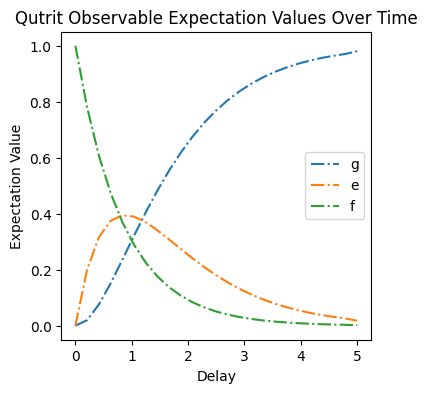

In [75]:
# Modify the experiment function for qutrits
def multi_qutrit_experiment(rho_initial, delay, trotter_step_size):
    # Initialize the qutrit amplitude damping channel with the provided gamma parameters
    error_channel = QutritAmplitudeDamping(0.1, k1, k2, trotter_step_size)
    rho_final = error_channel.apply_error_channel(rho_initial, delay)
    # Fidelity calculation for qutrits may need adjustment
    fid = fidelity(rho_initial, rho_final)
    return rho_final, fid


# Modify the plot function for qutrits
def plot_observable_decay_qutrits(state, observables, delays, trotter_step_size):
    plt.figure(figsize=(4, 4))
    for label, obs in observables.items():
        exp_values = []
        for delay in delays:
            rho_final, _ = multi_qutrit_experiment(state, delay, trotter_step_size)
            exp_value = expect(obs, rho_final)
            exp_values.append(exp_value)
        plt.plot(delays, exp_values, "-.", label=label)
    plt.legend()
    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Qutrit Observable Expectation Values Over Time")
    plt.show()


# Define the delays and gamma parameters
delays = np.linspace(0, 5, 25)
trotter_step_size
# Run the experiment
plot_observable_decay_qutrits(initial_state, observables, delays, trotter_step_size)

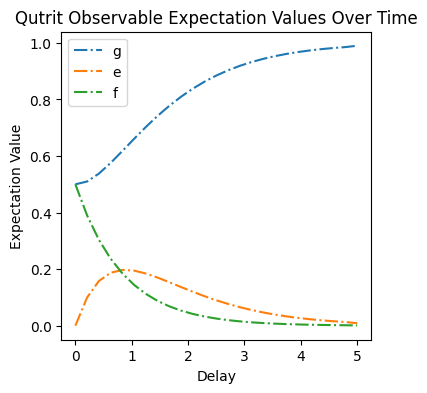

In [79]:
# Define encoded state to be [|g> + |f>]
encoded_state = basis(3, 0) + basis(3, 2)
encoded_state = encoded_state * encoded_state.dag()
encoded_state /= encoded_state.norm()

plot_observable_decay_qutrits(encoded_state, observables, delays, trotter_step_size)

In [81]:
class MultiQutritErrorChannel(ErrorChannel):
    def __init__(self, tau, k1, k2, trotter_dt, num_qutrits):
        self.num_qutrits = num_qutrits
        self.tau = tau
        self.k1 = k1
        self.k2 = k2
        self.trotter_dt = trotter_dt
        self.dims = 3**num_qutrits

        self.E = self._create_kraus_operators()
        super().__init__(trotter_dt, self.dims)

    def _create_kraus_operators(self):
        kraus_ops = []
        for _ in range(self.num_qutrits):
            # Initialize the single-qutrit amplitude damping channel
            single_qutrit_channel = QutritAmplitudeDamping(
                self.tau, self.k1, self.k2, self.trotter_dt
            )
            kraus_ops_single = single_qutrit_channel.E

            # Normalize if needed
            normalization_factor = np.sqrt(1 * N)
            normalized_ops = [op / normalization_factor for op in kraus_ops_single]

            kraus_ops.append(normalized_ops)

        # tensor wiith identity operators to create the multi-qutrit kraus operators
        multi_qutrit_kraus_ops = []
        for i in range(self.num_qutrits):
            for op in kraus_ops[i]:
                kraus_op_multi = [
                    op if k == i else qeye(3) for k in range(self.num_qutrits)
                ]
                multi_qutrit_kraus_ops.append(tensor(*kraus_op_multi))

        return multi_qutrit_kraus_ops

In [82]:
# Define the number of qubits
N = 2  # Number of qubits
delays = np.linspace(0, 5, 25)  # Sweeping delay from 0 to 10

# Initialize T1 and T2 times for each qubit
tau = 0.1  # not sure how to relate this to T1 yet
trotter_step_size = 0.2
k1, k2 = 1, 1

# Create initial states for a N-qubit system
d = 3
f_rho = basis(d, 2) * basis(d, 2).dag()  # |f><f|

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([f_rho] * N)
initial_state /= initial_state.norm()

# Define observables for two-qutrit system
observables = {
    "gg": tensor(g, g) * tensor(g, g).dag(),
    "ge": tensor(g, e) * tensor(g, e).dag(),
    "gf": tensor(g, f) * tensor(g, f).dag(),
    "eg": tensor(e, g) * tensor(e, g).dag(),
    "ee": tensor(e, e) * tensor(e, e).dag(),
    "ef": tensor(e, f) * tensor(e, f).dag(),
    "fg": tensor(f, g) * tensor(f, g).dag(),
    "fe": tensor(f, e) * tensor(f, e).dag(),
    "ff": tensor(f, f) * tensor(f, f).dag(),
}

In [83]:
def multi_qutrit_experiment(
    rho_initial, delay, trotter_step_size, tau, k1, k2, num_qutrits
):
    error_channel = MultiQutritErrorChannel(tau, k1, k2, trotter_step_size, num_qutrits)
    rho_final = error_channel.apply_error_channel(rho_initial, delay)
    fid = fidelity(rho_initial, rho_final)
    return rho_final, fid

In [84]:
def plot_observable_decay_qutrits(
    state, observables, delays, trotter_step_size, tau, k1, k2, num_qutrits
):
    plt.figure(figsize=(4, 4))
    for label, obs in observables.items():
        exp_values = []
        for delay in delays:
            rho_final, _ = multi_qutrit_experiment(
                state, delay, trotter_step_size, tau, k1, k2, num_qutrits
            )
            exp_value = expect(obs, rho_final)
            exp_values.append(exp_value)
        plt.plot(delays, exp_values, "-.", label=label)
    plt.legend()
    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Qutrit Observable Expectation Values Over Time")
    plt.show()

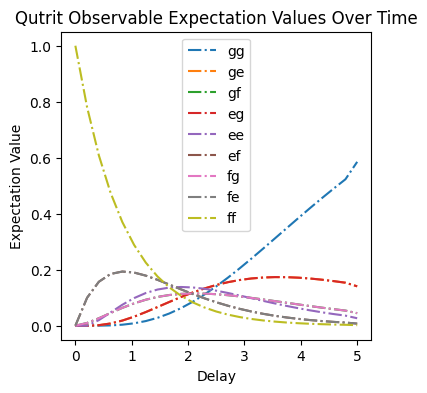

In [85]:
# Run the experiment
plot_observable_decay_qutrits(
    initial_state, observables, delays, trotter_step_size, tau, k1, k2, N
)

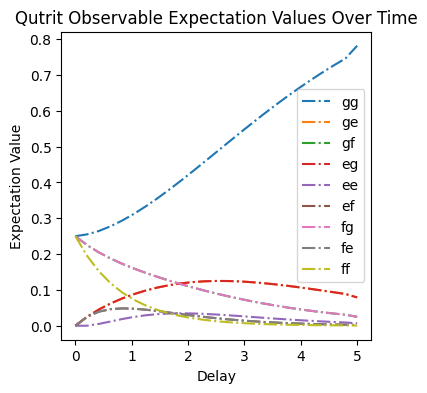

In [87]:
# Define encoded state to be [|g> + |f>]
encoded_state = basis(3, 0) + basis(3, 2)
encoded_state = encoded_state * encoded_state.dag()
encoded_state = tensor(encoded_state, encoded_state)
encoded_state /= encoded_state.norm()

plot_observable_decay_qutrits(
    encoded_state, observables, delays, trotter_step_size, tau, k1, k2, N
)